# <center>Audio Emotion Recognition</center>
## <center>Part 4 - Apply to new audio data</center>
#### <center> 31st August 2019 </center> 
#####  <center> Eu Jin Lok </center> 

## Introduction 
In [part 3](https://www.kaggle.com/ejlok1/audio-emotion-part-3-baseline-model) we built a simple baseline model and we serialise it. We also have an early indication of the accuracy to be expected across the 3 models namely 

- Gender at __81%__ absolute accuracy<br/>
- Emotion at __50%__ absolute accuracy<br/>
- Gender and Emotion at __43%__ absolute accuracy <br/>

So whilst it's all well and good in our little sandbox experiment here, question remains how well will it generalise across new unseen data? The accuracy measurement that we recorded above is based on the same dataset. Whilst we ensured the accuracy measure is based on a slice of the data that the model hasn't seen before, it is still made from the data source that will include the same speaker voice, the same audio quality, audio background etc. The model we trained could very well have picked up speakers unique characteristics rather than the audio features (data leakage). So how will this model perform once we apply it to a completely new dataset with different audio quality, speaker and background noises? It is here which we will run a quick test where I will record a new audio file and run it through the model  


1. [Audio Recording](#audio)
2. [Data preparation and prediction](#data)
3. [Final thoughts](#final)

Upvote this notebook if you like, and be sure to check out the other parts which are now available:
* [Part 5 | Data augmentation](https://www.kaggle.com/ejlok1/audio-emotion-part-5-data-augmentation)

Most importantly, I want to thank the 4 authors for their excellent dataset, without it, writing this notebook could not have been possible. The original source of the dataset links are below:

- [TESS](https://tspace.library.utoronto.ca/handle/1807/24487)
- [CREMA-D](https://github.com/CheyneyComputerScience/CREMA-D)
- [SAVEE](http://kahlan.eps.surrey.ac.uk/savee/Database.html)
- [RAVDESS](https://zenodo.org/record/1188976#.XYP8CSgzaUk)
- [RAVDESS_Kaggle](https://www.kaggle.com/uwrfkaggler/ravdess-emotional-speech-audio)

In [256]:
# Importing required libraries 
from keras._tf_keras.keras.models import model_from_json
from keras import Sequential, Model
from keras._tf_keras.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import keras 
import pickle
import wave  # !pip install wave
import os
import pandas as pd
import numpy as np
import sys
import warnings
import librosa.feature
import librosa.display
import IPython.display as ipd  # To play sound in the notebook

# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [257]:
data, sampling_rate = librosa.load(r"C:\Users\eo19181\Documents\All -  Datasets\ESD - Dataset\Female\Happy\0016_000702.wav")
ipd.Audio(r"C:\Users\eo19181\Documents\All -  Datasets\ESD - Dataset\Female\Happy\0016_000702.wav")

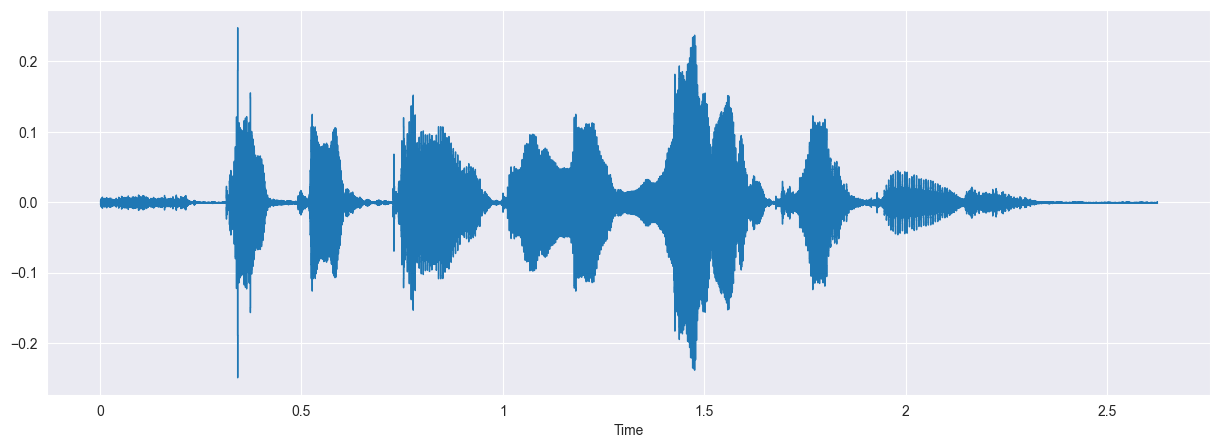

In [258]:
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

<a id="data"></a>
## 2. Data preparation and prediction
So what we're aiming for is __female_happy__ prediction as the correct answer. Now that we have the audio file ready, we'll need to convert it to the correct data format for our model, and we'll need the serialised models for the weights and the model architecture that we performed in [part 3](https://www.kaggle.com/ejlok1/audio-emotion-part-3-baseline-model). I'm not going to re-run the entire code just to get the files, so what I've done is downloaded the 'model_json.json' and 'Emotion_Model.h5' files and loaded it into this notebook. 

In [259]:
# loading json and model architecture 
json_file = open(r'C:\Users\eo19181\PycharmProjects\pythonProject\speech_emotion_analyser\model_json (epoch 100).json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights(r"C:\Users\eo19181\PycharmProjects\pythonProject\speech_emotion_analyser\saved_models\Emotion_Model (epoch 100).h5")
print("Loaded model from disk")

# the optimiser
opt = keras.optimizers.RMSprop(learning_rate=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Loaded model from disk


And next step transform the audio data...

In [260]:
# Lets transform the dataset so we can apply the predictions
X, sample_rate = librosa.load(r"C:\Users\eo19181\Documents\All -  Datasets\TESS - Dataset\Female\Surprise\OAF_bean_ps.wav"
                              ,res_type='kaiser_fast'
                              ,duration=2.5
                              ,sr=44100
                              ,offset=0.5
                             )

sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
newdf = pd.DataFrame(data=mfccs).T
newdf

,0,1,2,3,4,5,6,7,8,9,...,103,104,105,106,107,108,109,110,111,112
0,-18.697691,-22.059599,-30.357534,-29.286882,-28.717335,-29.072845,-29.019932,-28.517799,-28.518932,-28.880611,...,-43.222511,-42.50668,-40.217964,-39.971802,-39.753689,-40.731247,-41.571228,-40.120827,-37.390377,-36.799267


In [261]:
# import numpy as np
# from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming newdf is your DataFrame
newdf
print("DataFrame shape:", newdf.shape)

# Convert DataFrame to a list of sequences
sequences = newdf.values.tolist()

print("First sequence:", sequences[0])
print("Total sequences:", len(sequences))

# Define the target length
target_length = 216

# Pad sequences to ensure they match the target length
padded_sequences = pad_sequences(sequences, maxlen=target_length, padding='post', truncating='post')

print("Padded sequences shape:", padded_sequences.shape)

# Ensure the shape matches model requirements
target_shape = (len(padded_sequences), target_length)  # Adjust this based on your model's expected input shape

# If necessary, pad with zeros to match the target shape
if padded_sequences.shape[1] < target_length:
    padding = np.zeros((padded_sequences.shape[0], target_length - padded_sequences.shape[1]))
    padded_sequences = np.hstack((padded_sequences, padding))
elif padded_sequences.shape[1] > target_length:
    padded_sequences = padded_sequences[:, :target_length]

print("Final padded_sequences shape:", padded_sequences.shape)

# Expand dimensions to match the model input shape
newdf_expanded = np.expand_dims(padded_sequences, axis=2)

print("Expanded newdf shape:", newdf_expanded.shape)

# Verify model input shape
print("Model expected input shape:", loaded_model.input_shape)

# Apply predictions
newpred = loaded_model.predict(newdf_expanded, batch_size=16, verbose=1)

print("Prediction output:", newpred)

# Check if all predictions are zeros
if np.all((newpred == 0)):
    print("All predictions are zeros. Please check the model and input data.")
else:
    print("Predictions look good.")


DataFrame shape: (1, 113)
First sequence: [-18.697690963745117, -22.059598922729492, -30.357534408569336, -29.286882400512695, -28.717334747314453, -29.072845458984375, -29.01993179321289, -28.517799377441406, -28.518932342529297, -28.880611419677734, -30.14305877685547, -30.725202560424805, -29.173959732055664, -27.98213005065918, -27.328706741333008, -27.350872039794922, -27.789100646972656, -28.965421676635742, -30.888038635253906, -31.851423263549805, -32.17341995239258, -33.16358184814453, -32.27462387084961, -33.12571716308594, -32.051063537597656, -30.584205627441406, -29.614194869995117, -28.63665771484375, -28.48094940185547, -29.67825698852539, -29.786977767944336, -30.033334732055664, -28.7344970703125, -27.805381774902344, -27.89382553100586, -28.671764373779297, -30.57895851135254, -29.635969161987305, -29.062665939331055, -27.484628677368164, -26.472200393676758, -28.35859489440918, -27.74335479736328, -25.905244827270508, -25.10893440246582, -25.33737564086914, -26.52196

And finally run the predictions over it using our saved baseline model

In [262]:
# padded_sequences

In [263]:
# # import numpy as np
# # from tensorflow.keras.preprocessing.sequence import pad_sequences
# 
# # Assuming newdf is your DataFrame
# print("DataFrame head:\n", newdf.head())
# print("DataFrame shape:", newdf.shape)
# 
# # Convert DataFrame to a list of sequences
# sequences = newdf.values.tolist()
# 
# print("First sequence:", sequences[0])
# print("Total sequences:", len(sequences))
# 
# # Define the target length
# target_length = 192
# 
# # Pad sequences to ensure they match the target length
# padded_sequences = pad_sequences(sequences, maxlen=target_length, padding='post', truncating='post')
# 
# print("Padded sequences shape:", padded_sequences.shape)
# 
# # Ensure the shape matches model requirements
# target_shape = (len(padded_sequences), target_length)  # Adjust this based on your model's expected input shape
# 
# # If necessary, pad with zeros to match the target shape
# if padded_sequences.shape[1] < target_length:
#     padding = np.zeros((padded_sequences.shape[0], target_length - padded_sequences.shape[1]))
#     padded_sequences = np.hstack((padded_sequences, padding))
# elif padded_sequences.shape[1] > target_length:
#     padded_sequences = padded_sequences[:, :target_length]
# 
# print("Final padded_sequences shape:", padded_sequences.shape)


In [264]:
# # Apply predictions
# newdf= np.expand_dims(newdf, axis=2)
# newpred = loaded_model.predict(newdf, 
#                          batch_size=16, 
#                          verbose=1)
# 
# newpred

--------------------
The prediction is in the form of numbers, we'll need to append the labels to it before we can make sense as to what it has predicted... The labels code can be found again, in part 3, but instead of re-running it, i've just uploaded the file into this notebook. Its simple a mapping file between the labels and the ID pairs.

In [265]:
filename = 'speech_emotion_analyser/labels'
infile = open(filename,'rb')
lb = pickle.load(infile)
infile.close()

# Get the final predicted label
final = newpred.argmax(axis=1)
final = final.astype(int).flatten()
final = (lb.inverse_transform((final)))
print(final) #emo(final) #gender(final) 

['male_sad']


<a id="final"></a>
## 3. Final thoughts
So our model predicted __female surprise__, which on hindsight, going back listening to the audio again, I would actually agree with the prediction! Even thou I gave specific instructions to my wife to record a happy audio, I suppose the emotion exhibited is very similar to suprise. This is a very pleasant surprise indeed.  

In our next section we will be looking to enhance the model!